In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modeling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('E:/Data Science/Projects/final/Medical_Cost_Prediction/notebook/data/insurance.csv')

In [3]:
df.shape

(1338, 7)

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Data Cleaning

### Missing Values

In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Duplicate Values

In [6]:
df.duplicated().sum()

1

In [7]:
df[df.duplicated()==True]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df.shape

(1337, 7)

### Data Types

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


### Unique Values (in each column)

In [12]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

### Numerical columns statistics

In [13]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


### Removing Outliers

In [14]:
# # outliers from charges column
# q1 = df['charges'].quantile(0.25)
# q3 = df['charges'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5*iqr
# upper = q3 + 1.5*iqr
 
# # Create a mask to identify outliers
# outliers_mask = (df['charges'] < lower) | (df['charges'] > upper)

# # Drop the outliers from the DataFrame
# df = df[~outliers_mask]

In [15]:
# # outliers from bmi column
# q1 = df['bmi'].quantile(0.25)
# q3 = df['bmi'].quantile(0.75)
# iqr = q3 - q1
# lower = q1 - 1.5*iqr
# upper = q3 + 1.5*iqr
 
# # Create a mask to identify outliers
# outliers_mask = (df['bmi'] < lower) | (df['bmi'] > upper)

# # Drop the outliers from the DataFrame
# df = df[~outliers_mask]

In [16]:
df.shape

(1337, 7)

## Feature Engineering

### Numerical and Categorical Features

In [17]:
numerical_features = [feature for feature in df.columns if df[feature].dtype!='O']
categorical_features = [feature for feature in df.columns if df[feature].dtype=='O']
target = "charges"

print('We have {} numerical features : {}'.format(len(numerical_features), numerical_features))
print('We have {} categorical features : {}'.format(len(categorical_features), categorical_features))

print("\nCategories in 'sex' variable:     ",end=" " )
print(df['sex'].unique())

print("Categories in 'smoker' variable:  ",end=" ")
print(df['smoker'].unique())

print("Categories in'region' variable:",end=" " )
print(df['region'].unique())

We have 4 numerical features : ['age', 'bmi', 'children', 'charges']
We have 3 categorical features : ['sex', 'smoker', 'region']

Categories in 'sex' variable:      ['female' 'male']
Categories in 'smoker' variable:   ['yes' 'no']
Categories in'region' variable: ['southwest' 'southeast' 'northwest' 'northeast']


### Adding columns

In [18]:
# Adding an age_range categorical column where ages between 0-30 are considered 'young', 31-60 are considered 'middle-aged', and 61-100 are considered as 'old'
df['age_range'] = 'old'
df.loc[(df['age'] > 0) & (df['age'] <= 30), 'age_range'] = 'young'
df.loc[(df['age'] > 30) & (df['age'] <= 60), 'age_range'] = 'middle-aged'
df.head()

,age,sex,bmi,children,smoker,region,charges,age_range
0,19,female,27.900,0,yes,southwest,16884.92400,young
1,18,male,33.770,1,no,southeast,1725.55230,young
2,28,male,33.000,3,no,southeast,4449.46200,young
3,33,male,22.705,0,no,northwest,21984.47061,middle-aged
4,32,male,28.880,0,no,northwest,3866.85520,middle-aged


In [19]:
# Adding a bmi_range categorical column where bmi <18.5 falls under underweight range, 18.5 - 24.9 falls under normal range, 25.0 - 29.9 falls under overweight range, and >30.0 falls under obese range
df['bmi_range'] = 'normal'
df.loc[(df['bmi'] < 18.5), 'bmi_range'] = 'underweight'
df.loc[(df['bmi'] > 25.0) & (df['bmi'] < 29.9), 'bmi_range'] = 'overweight'
df.loc[(df['bmi'] > 30.0), 'bmi_range'] = 'obese'
df.head()

,age,sex,bmi,children,smoker,region,charges,age_range,bmi_range
0,19,female,27.900,0,yes,southwest,16884.92400,young,overweight
1,18,male,33.770,1,no,southeast,1725.55230,young,obese
2,28,male,33.000,3,no,southeast,4449.46200,young,obese
3,33,male,22.705,0,no,northwest,21984.47061,middle-aged,normal
4,32,male,28.880,0,no,northwest,3866.85520,middle-aged,overweight


## Modeling

In [20]:
# Excluding age_range and bmi_range
X1 = df.drop(columns=['age_range', 'bmi_range', 'charges'], axis=1)
y = df['charges']

# Excluding age and bmi
X2 = df.drop(columns=['age', 'bmi', 'charges'], axis=1)

In [21]:
# Data Preprocessing
num_features = X2.select_dtypes(exclude='object').columns
cat_features = X2.select_dtypes(include='object').columns

scaler = StandardScaler()
oh_encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder',oh_encoder,cat_features),
        ('StandardScaler',scaler,num_features)
    ]
)

In [22]:
print(num_features)
print(cat_features)

Index(['children'], dtype='object')
Index(['sex', 'smoker', 'region', 'age_range', 'bmi_range'], dtype='object')


In [23]:
X2 = preprocessor.fit_transform(X2)

In [24]:
X2

array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -0.90923416],
       [ 0.        ,  1.        ,  1.        , ...,  0.        ,
         0.        , -0.07944162],
       [ 0.        ,  1.        ,  1.        , ...,  0.        ,
         0.        ,  1.58014347],
       ...,
       [ 1.        ,  0.        ,  1.        , ...,  0.        ,
         0.        , -0.90923416],
       [ 1.        ,  0.        ,  1.        , ...,  1.        ,
         0.        , -0.90923416],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -0.90923416]])

In [25]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1069, 16), (268, 16))

In [26]:
# evaluate_model function to calculate all the metrics after model training
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    r2 = r2_score(true, predicted)
    rmse = np.sqrt(mse)
    return mae, mse, r2, rmse

In [27]:
# Model training
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]

    # Training
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluations
    model_train_mae, model_train_mse, model_train_r2, model_train_rmse = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_mse, model_test_r2, model_test_rmse = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 6346.8595
- Mean Absolute Error: 4620.9591
- R2 Score: 0.7058
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6481.3531
- Mean Absolute Error: 4801.4457
- R2 Score: 0.7714


Lasso
Model performance for Training set
- Root Mean Squared Error: 6346.8706
- Mean Absolute Error: 4620.2883
- R2 Score: 0.7058
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6480.6881
- Mean Absolute Error: 4800.2618
- R2 Score: 0.7714


Ridge
Model performance for Training set
- Root Mean Squared Error: 6347.0295
- Mean Absolute Error: 4620.7810
- R2 Score: 0.7058
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6481.7425
- Mean Absolute Error: 4800.2876
- R2 Score: 0.7714


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5193.4439
- Mean Absolute Error: 3506.4397


In [28]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2 Score']).sort_values(by=['R2 Score'], ascending=False)

,Model Name,R2 Score
5,Random Forest Regressor,0.870047
7,CatBoosting Regressor,0.865424
4,Decision Tree,0.860215
8,AdaBoost Regressor,0.860121
6,XGBRegressor,0.854155
3,K-Neighbors Regressor,0.798090
1,Lasso,0.771440
0,Linear Regression,0.771393
2,Ridge,0.771365


In [29]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred) * 100

print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 86.97


Text(0, 0.5, 'Predicted')

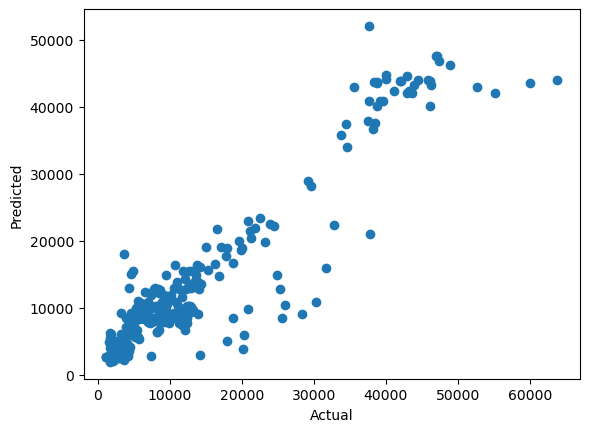

In [30]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

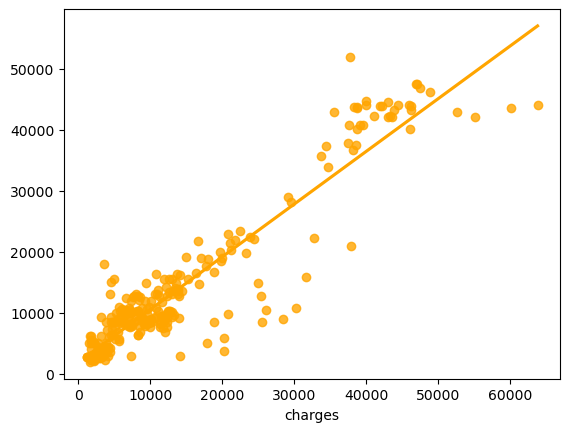

In [31]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='orange');

In [32]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
900,8688.85885,9085.231049,-396.372199
1064,5708.86700,8345.407035,-2636.540035
1256,11436.73815,8519.053015,2917.685135
298,38746.35510,43522.465538,-4776.110438
237,4463.20510,8538.938999,-4075.733899
...,...,...,...
534,13831.11520,12995.357022,835.758178
542,13887.20400,13839.360872,47.843128
760,3925.75820,7143.468786,-3217.710586
1284,47403.88000,46845.003224,558.876776


In [33]:
import pickle
pickle.dump(rf,open('model.pkl','wb'))